In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import csv
import gc

#### change HERE ####
path = Path('transcript_data')
#####################

In [2]:
#define methods

#returns format {transcript_id : {exon_id : chromosome_start}}, {transcript_id : {exon_id : start}}, {transcript_id : {exon_id : end}}, pandas DataFrame [exon_id, transcript_id, chrom_exon_start, chrom_exon_end]
def calc_exon_data(path):
    feather_file = Path(path/'exon_info.feather')
    if feather_file.is_file():
        #load file from disk
        exon_info = pd.read_feather(feather_file)
    else:
        chrom_exon_starts = read_in_fasta(path/'all_exon_start.fasta')
        chrom_exon_ends = read_in_fasta(path/'all_exon_end.fasta')
        exon_info = {}
        for tid in chrom_exon_starts:
            sorted_ = {k: v for k, v in sorted(chrom_exon_starts[tid].items(), key=lambda item: item[1])}
            for eid in sorted_:
                chrom_exon_start = chrom_exon_starts[tid][eid]
                chrom_exon_end = chrom_exon_ends[tid][eid]
                exon_info[eid] = [tid, chrom_exon_start, chrom_exon_end]
                #write to disk
        exon_info = pd.DataFrame.from_dict(exon_info, orient='index', columns=['transcript_id','chrom_exon_start', 'chrom_exon_end']).reset_index()
        exon_info = exon_info.rename(columns={'index': "exon_id"})
        exon_info.to_feather(feather_file)
    return exon_info

def read_in_ensembl_exon_info(path):
    df_gene = pd.read_csv(path/'gene_infos.csv', dtype={'ensembl_gene_id':str,'ensembl_gene_id_version':str,'ensembl_transcript_id':str, 'ensembl_transcript_id_version':str, 'chromosome_name':'category', 'strand':'int8', 'start_position':int, 'end_position':int})
    del df_gene['Unnamed: 0']
    df_gene[['strand']] = df_gene[['strand']].astype('str').astype('category')
    df_exon = calc_exon_data(path) # exon starts and ends per transcript + exon id
    df_exon = df_exon.merge(df_gene, left_on = 'transcript_id', right_on = 'ensembl_transcript_id', how='left')
    df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']] = df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']].astype('Int64')
    df_exon['chromosome_name'] = df_exon['chromosome_name'].apply((lambda x: (x[4:] if x.startswith('CHR') else x)))
    df_exon[['strand']] = df_exon[['strand']].astype('str').astype('category')
    return df_exon

# read exon position dictionary from file
# returns format {transcript_id : {exon_id : (exon_start, exon_end, chromosome_exon_start)}}
def read_in_exon_pos(file):
    exon_positions = {}
    with open(file,'r') as data: 
        for line in csv.reader(data): 
            tid, eid, exon_start, exon_end, chrom_exon_start = line
            exon_positions[tid] = exon_positions.get(tid,{})
            exon_positions[tid][eid] = (int(exon_start),int(exon_end),int(chrom_exon_start))
    sorted_dict1 = {}
    for t in exon_positions:
        dict1 = exon_positions[t]
        sorted_values = sorted(dict1.values()) # Sort the values
        sorted_dict = {}
        for i in sorted_values:
            for k in dict1.keys():
                if dict1[k] == i:
                    sorted_dict[k] = dict1[k]
                    break
        sorted_dict1[t] = sorted_dict1.get(t,{})
        sorted_dict1[t].update(sorted_dict)
    return sorted_dict1

def calc_chrom_pos(start, end, exon_pos):
    start_chrom_pos = False
    eids = []
    for eid, data in exon_pos.items():
        exon_start = data[0]
        exon_end = data[1]
        chrom_exon_start = data[2]
        if (start >= exon_start) and (start <= exon_end):
            start_chrom_pos = chrom_exon_start + (start - exon_start)
            if (end >= exon_start) and (end <= exon_end):
                end_chrom_pos = chrom_exon_start + (end - exon_start)
                return start_chrom_pos, end_chrom_pos, eid, 1
            else: eids.append(eid)   
        elif (end >= exon_start) and (end <= exon_end):
            end_chrom_pos = chrom_exon_start + (end - exon_start)
            eids.append(eid)
            return start_chrom_pos, end_chrom_pos, ','.join(eids), len(eids)
        elif start_chrom_pos: #in case of bindingsites spanning > 2 exons
            eids.append(eid)
    return None, None, None, None

def chrom_pos(df, exon_positions):
    v1s, v2s, v3s, v4s = [], [], [], []
    i = 0
    for _, row in df.iterrows():
        v1, v2, v3, v4 = calc_chrom_pos(row.bs_start, row.bs_end, exon_positions[row.mRNA])
        if i % 5000 == 0:
            gc.collect()
        v1s.append(v1)
        v2s.append(v2)
        v3s.append(v3)
        v4s.append(v4)
        i += 1
    print('Done computation')
    df_result = pd.DataFrame({'chrom_bs_start': v1s,
                            'chrom_bs_end': v2s,
                            'exon_id': v3s,
                            'nr_exons': v4s})
    df_result = df_result.set_index(df.index)
    df = pd.concat([df,df_result], axis=1)
    gc.collect()
    return df

## Prepare TarPmiR bindingsites

In [ ]:
#read in TarPmiR bindingsites directly after TarPmiR execution
bs = pd.read_parquet(path/'bs_tarp_all.parquet')

updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/ (stored 0%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_position_of_longest_consecutive_pairings.png (deflated 13%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/nr_mRNA.png (deflated 21%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_energy.png (deflated 14%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_pairings_in_3prime_end.png (deflated 12%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_number_of_pairings.png (deflated 15%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_longest_consecutive_pairings.png (deflated 14%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_AU_content.png (deflated 14%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-reg/data/plots/hist_seed.png (deflated 15%)
updating: nfs/home/users/l.hackl/alt-splicing-mirna-re

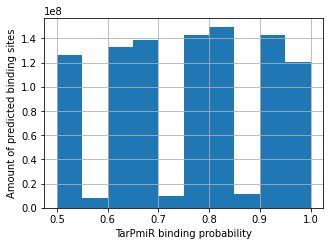

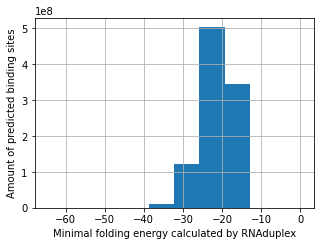

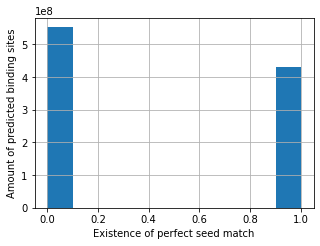

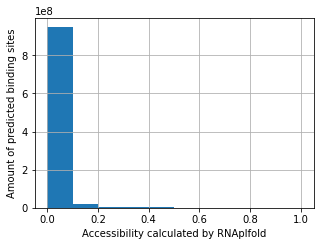

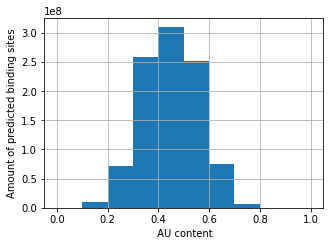

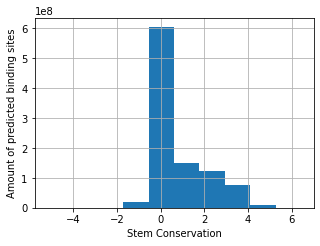

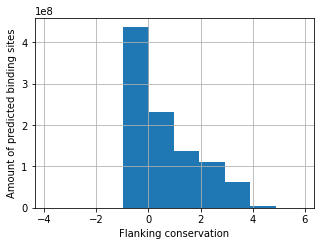

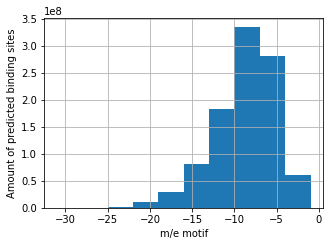

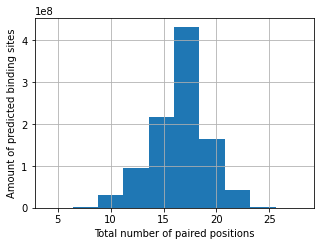

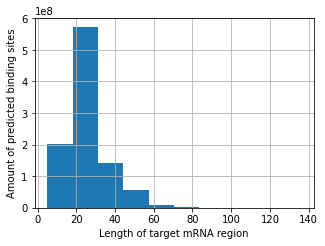

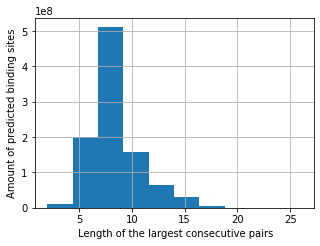

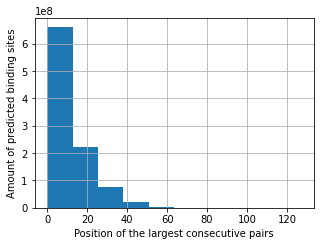

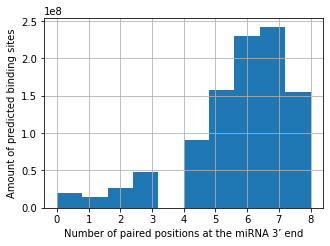

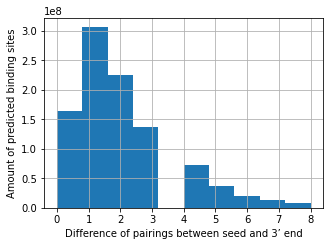

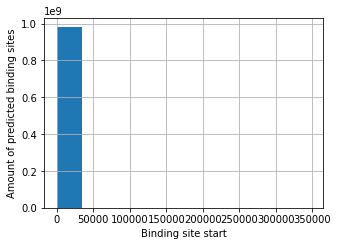

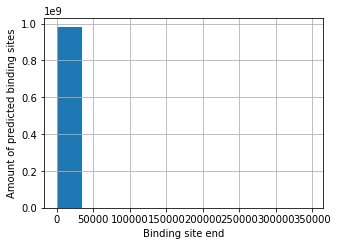

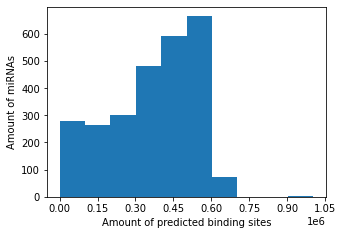

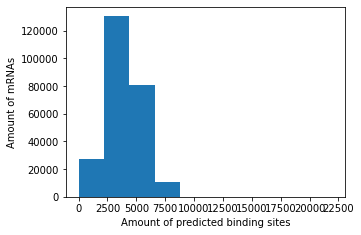

In [17]:
#plot tarpmir output features
x = ['TarPmiR binding probability','Minimal folding energy calculated by RNAduplex','Existence of perfect seed match','Accessibility calculated by RNAplfold',' AU content',
     'Stem Conservation','Flanking conservation','m/e motif','Total number of paired positions','Length of target mRNA region',' Length of the largest consecutive pairs',
     'Position of the largest consecutive pairs','Number of paired positions at the miRNA 3’ end','Difference of pairings between seed and 3’ end','Binding site start','Binding site end']
bs.rename(columns = {'m/e ':'m_e'}, inplace = True)
columns = [col for col in bs.columns if col not in ['miRNA','mRNA']]
for i in range(len(columns)):
    column = columns[i]
    fig1, ax1 = plt.subplots(figsize=(5,3.5))
    bs[column].hist()
    plt.xlabel(x[i])
    plt.ylabel('Amount of predicted binding sites')
    plt.savefig(path/'plots'/f'hist_{column}.png',dpi=200)

#number mirnas per number predicted bs 
fig1, ax1 = plt.subplots(figsize=(5,3.5))
mirnas = bs.groupby('miRNA').mRNA.count()
mirnas.plot(kind='hist')
plt.ylabel('Amount of miRNAs')
plt.xlabel('Amount of predicted binding sites')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(path/'plots'/'nr_miRNA.png',dpi=200)

#number mrnas per number predicted bs 
fig1, ax1 = plt.subplots(figsize=(5,3.5))
mrnas = bs.groupby('mRNA').miRNA.count()
mrnas.plot(kind='hist')
plt.ylabel('Amount of mRNAs')
plt.xlabel('Amount of predicted binding sites')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(path/'plots'/'nr_mRNA.png',dpi=200)

### Translate binding site positions from transcript to chromosome and add exon ID

In [6]:
#translate transcript position to position on chromosome and add exon id
exon_positions = read_in_exon_pos(path/'exon_positions.csv') # mapping of transcript ids to exon ids, chrom_exon_starts, exon_starts, exon_ends
bs = bs[['mRNA','bs_start','bs_end']]
bs['mRNA'] = pd.Categorical(bs.mRNA)
bs = chrom_pos(bs, exon_positions)
bs.chrom_bs_start = pd.to_numeric(bs.chrom_bs_start, downcast='integer')
bs.chrom_bs_end = pd.to_numeric(bs.chrom_bs_end, downcast='integer')
bs.nr_exons = pd.to_numeric(bs.nr_exons, downcast='integer')
bs[['mRNA','chrom_bs_start','chrom_bs_end','exon_id','nr_exons']].to_parquet(path/'bs_tarp_chrom.parquet')
bs

,mRNA,chrom_bs_start,chrom_bs_end,exon_id,nr_exons
0,ENST00000476331,12736769.0,12736808.0,ENSE00003612422,1
1,ENST00000476331,12738143.0,12738161.0,ENSE00003547358,1
2,ENST00000476331,12735555.0,12735600.0,ENSE00003550464,1
3,ENST00000476331,12734647.0,12734671.0,ENSE00003465197,1
4,ENST00000476331,12736786.0,12736808.0,ENSE00003612422,1
...,...,...,...,...,...
983499264,ENST00000511501,151409354.0,151409414.0,ENSE00002039741,1
983499265,ENST00000511501,151409432.0,151409448.0,ENSE00002039741,1
983499266,ENST00000511501,151409369.0,151409379.0,ENSE00002039741,1
983499267,ENST00000511501,151409393.0,151409417.0,ENSE00002039741,1


### Add chromosome and strand to binding sites using transcript ID

In [ ]:
df_exon = read_in_ensembl_exon_info(path)
df_tran = df_exon[['ensembl_transcript_id','chromosome_name','strand']]
bs = bs.merge(df_tran, left_on='mRNA', right_on='ensembl_transcript_id', how='left')
bs.drop(['mRNA'], axis=1, inplace=True)
bs.to_parquet(path/'bs_tarp_chrom_strand.parquet')
#plot nr_exons per bs
fig1, ax1 = plt.subplots(figsize=(8,5))
bs.nr_exons.hist()
plt.ylabel('Amount of predicted binding sites')
plt.xlabel('Amount of exons')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(path/'plots'/'exons_per_bs.png',dpi=200)

### Filter for binding sites with 1 exon

In [ ]:
#add more columns
bs_all = pd.read_parquet(path/'bs_tarp_all.parquet')
bs = pd.concat([bs,bs_all], axis=1).drop(['mRNA'],axis=1)
#add ensembl gene id
df_exon = read_in_ensembl_exon_info(path)
tran2gene = df_exon[['transcript_id','ensembl_gene_id']].drop_duplicates()
bs_temp = bs['ensembl_transcript_id']
bs_temp = pd.DataFrame(bs_temp).merge(tran2gene,left_on=['ensembl_transcript_id'],right_on=['transcript_id'],how='left').drop(['transcript_id','ensembl_transcript_id'], axis=1)
bs = pd.concat([bs, bs_temp.set_index(bs.index)], axis=1)
bs = bs[bs.nr_exons == 1].drop('nr_exons',axis=1)
bs.to_parquet(path/'bs_tarp_all_filtered.parquet')

#take subset of columns
bs = bs[['miRNA','exon_id','ensembl_transcript_id','ensembl_gene_id','binding_probability']]
bs.to_parquet(path/'bs_tarp_subset_filtered.parquet')

#plot TarPmiR binding probability after filtering bs on 1 exon 
fig1, ax1 = plt.subplots(figsize=(8,5))
bs.binding_probability.hist()
plt.ylabel('Amount of filtered binding sites')
plt.xlabel('TarPmiR binding probability')
plt.savefig(path/'plots'/'filtered_bind_prob.png',dpi=200)

### Filter binding sites by TarPmiR binding probability

In [ ]:
bs = bs[bs.binding_probability > 0.8]
bs.to_parquet((path/'bs_tarp_subset_filtered_0.8.parquet'))
#plot nr same mirna bs on one exon after filtering bs on 1 exon & binding probability
fig1, ax1 = plt.subplots(figsize=(8,5))
df = bs.groupby(['miRNA','exon_id']).binding_probability.count()
df.hist(bins=30)
plt.ylabel('Amount of filtered binding sites')
plt.xlabel('Amount of binding sites for one (miRNA,exon) pairing')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.yscale("log")
plt.savefig(path/'plots'/'bs_per_exon_log.png',dpi=200)

### Add gene version information

In [ ]:
df_exon = read_in_ensembl_exon_info(path)
df_exon = df_exon[['ensembl_gene_id','ensembl_gene_id_version']]
df_exon = df_exon.drop_duplicates()
bs_old = bs.copy()
bs = pd.DataFrame(bs_old).merge(df_exon,how='left',on='ensembl_gene_id')
bs['index'] = bs_old.index
bs = bs.set_index('index')
bs.to_parquet(path/'bs_tarp_subset_filtered_0.8_gene_version.parquet')

### Extract mirna-exon interactions

In [ ]:
bs[bs.duplicated(subset=['miRNA','exon_id'])]
bs_per_miRNA_exon = bs.groupby(['miRNA','exon_id']).agg({'ensembl_transcript_id':'first','ensembl_gene_id':'first','ensembl_gene_id_version':'first','binding_probability':lambda x: list(x)})
bs_per_miRNA_exon.to_parquet(path/'bs_tarp_subset_filtered_0.8_gene_version_per_mirna_exon.parquet')